# 1. Exploratory Data Analysis
### Udacity Machine Learning Engineer Capstone Project


In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from utils.plots import plot_categorical_distribution

sns.set_context("talk")

In [85]:
# set some jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# define color and font characteristics for the print function
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# set color palette
sns.set_palette(sns.diverging_palette(220, 20, n=2))


In [87]:
no_show_df = pd.read_csv("data/KaggleV2-May-2016 2.csv")
no_show_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Dataset description

The [Medical Appointment No Show dataset](https://www.kaggle.com/joniarroba/noshowappointments) uploaded on Kaggle by the user [JoniHoppen](https://www.kaggle.com/joniarroba) collects the data of appointments in public hospitals in Victoria (Brazil), focusing on whether the patient showed up to the appointment or not. 

This is the information available from the dataset page on Kaggle:

- **PatientId** - The identifier for each patient
- **AppointmentId** - The identifier for each appointment
- **Gender** - Sex of the patient (binary encoding, only values possible are male/female)
- **ScheduledDay** - Probably equivalent to "DataAgendamento", described as "The day someone called or registered the appointment, this is before appointment of course." 
- **AppointmentDay** - Probably equivalent to "DataMarcacaoConsulta", described as "The day of the actuall appointment, when they have to visit the doctor."
- **Age** - The age of the patient
- **Neighbourhood** - The neighborhood where the hospital is located. Does not refer to the patient
- **Scholarship** - Boolean feature refering to the [Bolsa Familia](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
- **Hipertension** - Boolean feature
- **Diabetes** - Boolean feature
- **Alcoholism** - Boolean feature
- **Handcap** - The number of disabilities that a patient has
- **SMS_received** - Boolean feature representing whether an SMS reminder has been sent to the patient
- **No-show** - Whether the patient showed up to the appointment or not. Binary feature with values "Yes" and "No"

Now, let's describe the dataset and do a quick validation of the data format before enforcing one.


In [88]:
no_show_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


All looks in line with the expectations, aside "Age": the minimum value is -1, which is probably a missing value instead, and the maximum is 115, which appears highly unlikely when looking at lists of [verified oldest people on Wikipedia](https://en.wikipedia.org/wiki/Oldest_people). We will deal with this variable further down in the analysis.

## Dataset preparation

After a first level sanity check, the data types that were originally inferred by pandas.read_csv() can be set manually based on what we currently know about the dataset. 

In [89]:
# In order to speed up further analysis, I'll rename columns to be consistent
# (all camelCase as it's the prevalent convention in the dataset) and remove spelling mistakes
# Also, appropriate data types will be set for all columns
# NOTE: from the dataset documentation, 'SMS_received' is a boolean variable representing 
#       if one or more SMS have been *SENT* to the patient. The name will be changed accordingly

new_column_names_and_formats = {"patientId": "str",
                                "appointmentId": "str",
                                "gender": "category",
                                "scheduledDay": "datetime64",
                                "appointmentDay": "datetime64",
                                "age": "int8",
                                "neighborhood": "category",
                                "scholarship": "bool",
                                "hypertension": "bool",
                                "diabetes": "bool",
                                "alcoholism": "bool",
                                "handicap": "int8",
                                "smsSent": "bool",
                                "noShow": "category"}

no_show_df.columns = list(new_column_names_and_formats.keys())
no_show_df = no_show_df.astype(new_column_names_and_formats)

# some further fine tuning of the dataset
no_show_df["noShow"] = no_show_df["noShow"].replace({"No":0,"Yes":1}).astype("bool")
no_show_df["patientId"] = no_show_df["patientId"].str[:-2] # remove the '.0' originated by the conversion to string

no_show_df.head()

,patientId,appointmentId,gender,scheduledDay,appointmentDay,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsSent,noShow
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,0,False,False
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,0,False,False
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,False,False,False,False,0,False,False
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,0,False,False
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,0,False,False


In [90]:
# drop possible duplicated row
starting_n_rows = len(no_show_df)
no_show_df = no_show_df.drop_duplicates()
print("{} row(s) removed".format(starting_n_rows - len(no_show_df)))

0 row(s) removed


Now we can continue with some due diligence. We start by checking if any missing value is present.

In [91]:
# are there missing values?
count_na = no_show_df.isna().sum()

if not count_na.any():
    print("All rows are populated in every column!")
else:
    print("Some missing values have been detected")
print("")
print(count_na)

All rows are populated in every column!

patientId         0
appointmentId     0
gender            0
scheduledDay      0
appointmentDay    0
age               0
neighborhood      0
scholarship       0
hypertension      0
diabetes          0
alcoholism        0
handicap          0
smsSent           0
noShow            0
dtype: int64


### Moving forward

It's time to structure the data analysis. Here are the steps I will follow:
- I'll start by having quick look over the variables, mostly applying standard and custom functions, to identify the most interesting variables to focus on for cleaning the data and building new features. The order that I will follow is:
    - I will start by looking at the keys in the dataset: patientId and appointmentId
    - I will then analyze the binary features, followed by the numeric and categorical features
    - Finally, I'll look into the datetime variables
- Then, based on the learnings, I will proceed by:
    - Looking into each of the most important variables and how they interact with other features
    - Remove the records that present data quality issues
    - Construct new features based on the insights gained in the data exploration.

## High level exploration
Let's go through column by column and let's analyze them and build features



### Patient and appointment IDs
**Expectations:** the column appointmentId should be the key identifier of the row, while there could be multiple occurrences for each patientId value. 

It would also be interesting to observe how often patients appointment happened in this month

In [92]:
# let's begin by checking that appointmentId is unique
assert no_show_df.appointmentId.nunique() == no_show_df.shape[0], "The variable appointmentId is not unique"

print("All expectations in the block were met!")

All expectations in the block were met!


In [93]:
# plot a histogram of occurrence for the patientId column
patients_count = no_show_df.groupby('patientId')['appointmentId'].nunique().reset_index()
patients_count.sort_values(by="appointmentId",ascending=False).head(10)

,patientId,appointmentId
49247,822145925426128,88
61952,99637671331,84
11422,26886125921145,70
15726,33534783483176,65
53068,871374938638855,62
36006,6264198675331,62
10591,258424392677,62
45116,75797461494159,62
39126,66844879846766,57
53142,872278549442,55


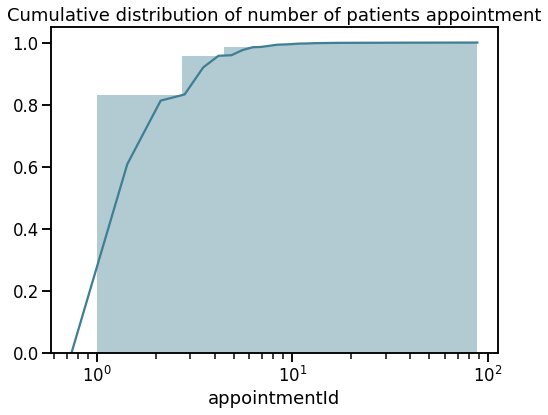

In [94]:
plt.figure(figsize=(8,6))
sns_kwargs = {'cumulative': True}
ax = sns.distplot(patients_count.appointmentId,hist_kws=sns_kwargs,kde_kws=sns_kwargs)
ax.set_title("Cumulative distribution of number of patients appointment")
ax.set(xscale="log")
plt.show()

**Observations:**

Roughly 80% of the patients have only one appointment. The maximum reached is 88 appointment per patient (worth to look into those extreme cases after).

### Categorical features

In [95]:
# and on the remaining columns
no_show_df.describe(include=["category","boolean"])

,gender,neighborhood,scholarship,hypertension,diabetes,alcoholism,smsSent,noShow
count,110527,110527,110527,110527,110527,110527,110527,110527
unique,2,81,2,2,2,2,2,2
top,F,JARDIM CAMBURI,False,False,False,False,False,False
freq,71840,7717,99666,88726,102584,107167,75045,88208


All these features have only two unique values, except for neighborhood which has 81 unique values. We will look into that variable later.

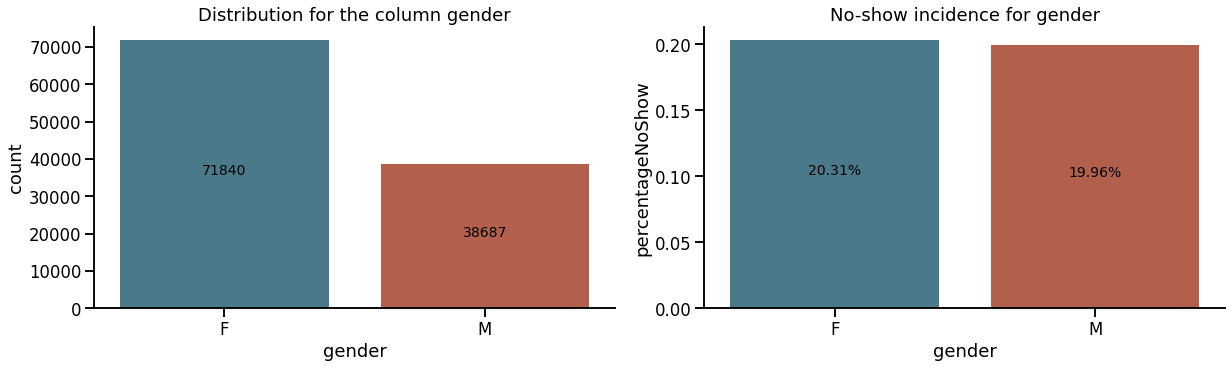


The distributions of no-show between gender = F and gender = M are not statistically different
p-value: 0.17091967598406582


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



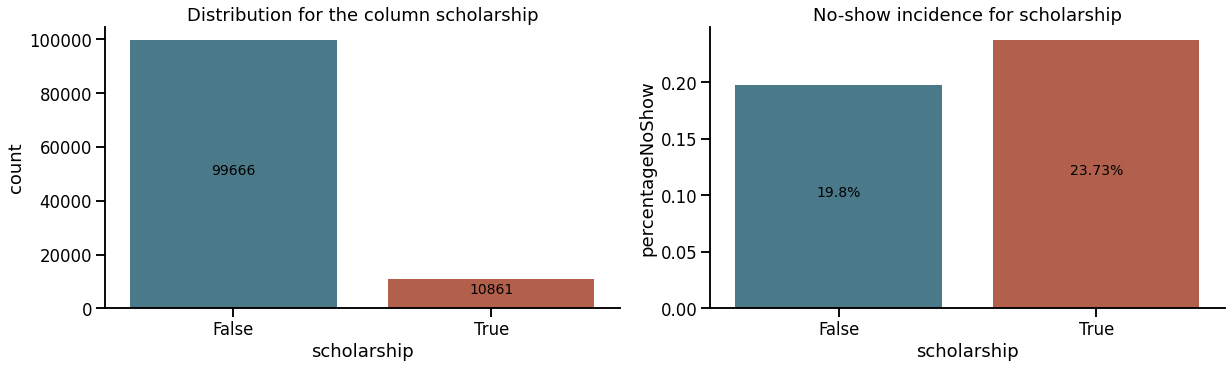


The distributions of no-show between scholarship = False and scholarship = True are statistically different with a significance of 95%
p-value: 3.3889403317338743e-22


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



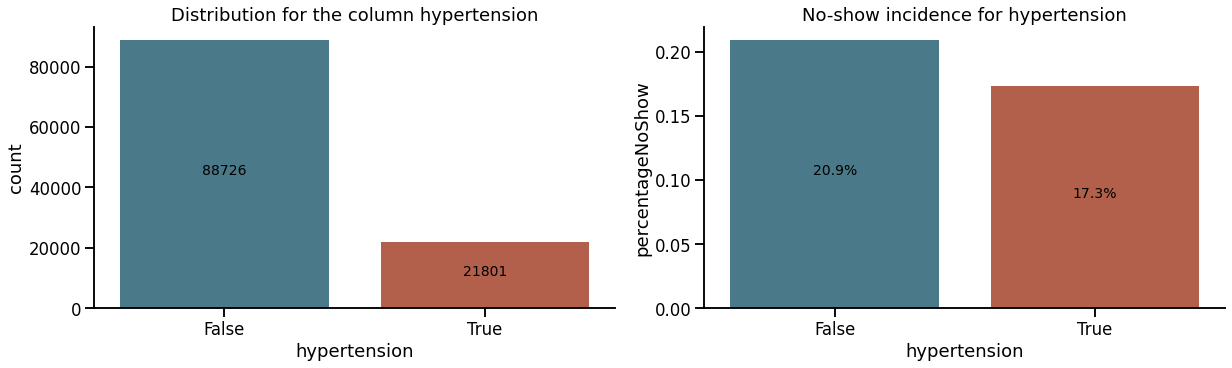


The distributions of no-show between hypertension = False and hypertension = True are statistically different with a significance of 95%
p-value: 1.6404310625035118e-32


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



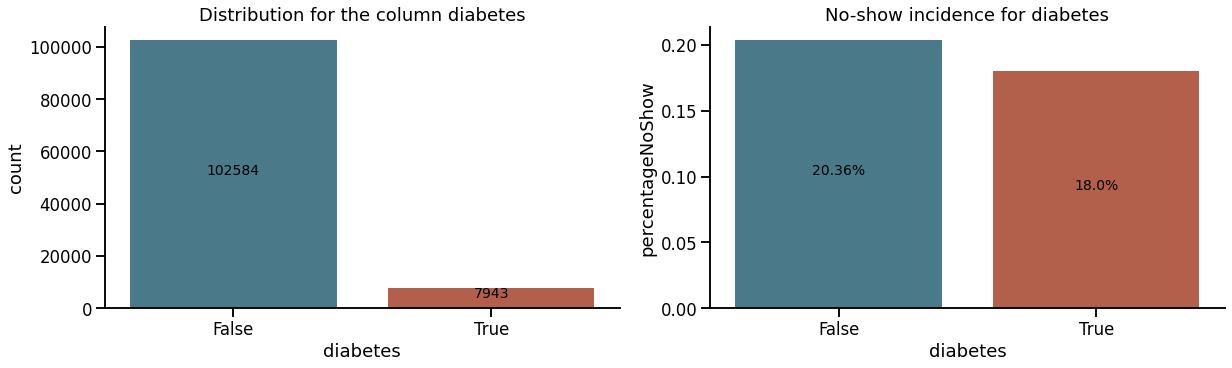


The distributions of no-show between diabetes = False and diabetes = True are statistically different with a significance of 95%
p-value: 4.490426322246223e-07


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



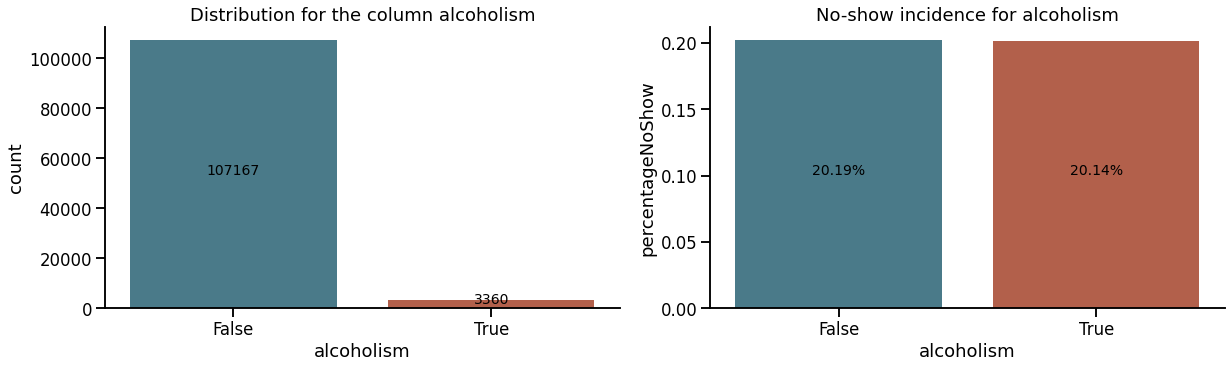


The distributions of no-show between alcoholism = False and alcoholism = True are not statistically different
p-value: 0.9480345241232874


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



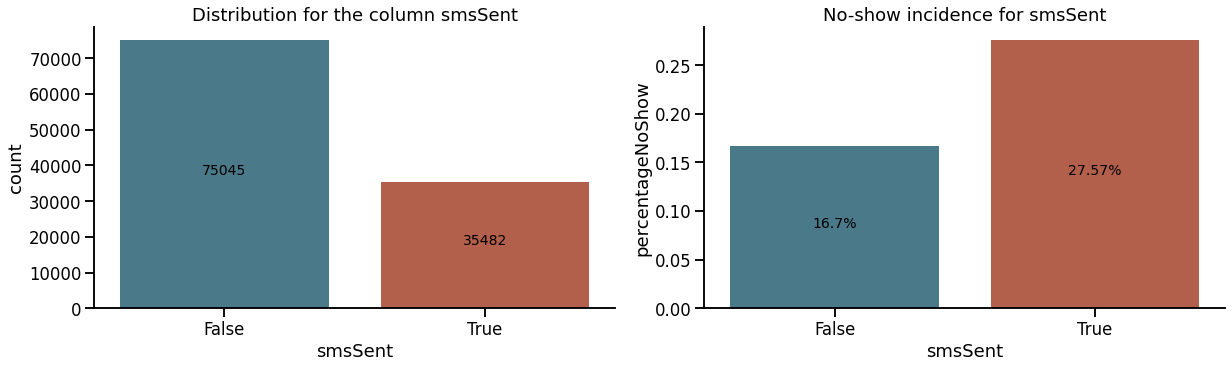


The distributions of no-show between smsSent = False and smsSent = True are statistically different with a significance of 95%
p-value: 0.0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



In [96]:
## Here I'll use a user defined variable imported in the first module (utils.plot_categorical_distribution)
## to quickly analyze the binary variables

#get categorical no_show_df["hypertension"]l columns
target_var = 'noShow'
columns_to_exclude = 'neighborhood'
categorical_columns = [column for column in no_show_df.select_dtypes(["category","boolean"]).columns 
                       if column != target_var and column != columns_to_exclude]
# now plot them
for column in categorical_columns:
    plot_categorical_distribution(no_show_df,column,target_var)
    print()
    print(" ".join(["-"]*59))
    print()

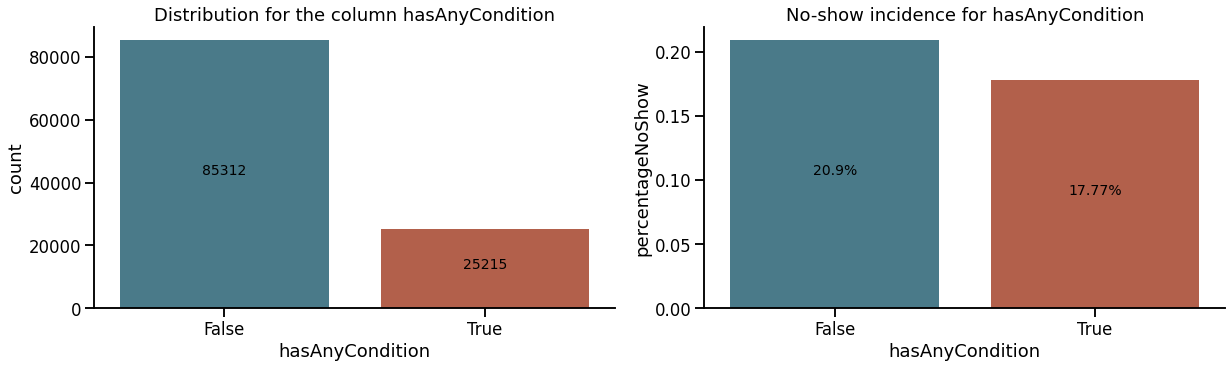


The distributions of no-show between hasAnyCondition = False and hasAnyCondition = True are statistically different with a significance of 95%
p-value: 1.057751243264767e-27



In [97]:
# let's try to create a variable to group patients with any known conditions
no_show_df["hasAnyCondition"] = no_show_df["hypertension"] + no_show_df["diabetes"] + no_show_df["alcoholism"]
plot_categorical_distribution(no_show_df,"hasAnyCondition","noShow")

**Observations:**

* Appointments for which an SMS reminder was sent are more likely to result in a patient no-show. This probably means that the hospitals already have a way to select patients that might not show up to appointments.
* The percentage of no-show for the remaining variables remains relatively consistent for the different values that those categories assume. A hypothesis testing on the distribution shows that:
    - The features'gender' and 'alcholism' do not show a different 'noShow' distribution across their values (meaning that males and females, and alcoholics and non-alcoholics do not show a different behavior when it comes to hospital no-show). The two genders are not balanced in the dataset, however this shouldn't be a problem as they don't show a different behavior when it comes no show.
    - Patients with diabetes and hypertension seem to have a lower no-show rate
    - Patients who received the scholarship (governmental subsidy) have a higher no-show rate. Given that the subsidy is linked to the income, this might be caused by an increased difficulty for low-income populations to access to the public healthcare.

**Next steps:**
* Further investigate the distribution of smsSent comparing it with the other variables

### Age and Handicap


In [98]:
# first of all, let's look at the extreme values
num_outliers = len(no_show_df.loc[(no_show_df.age < 0) | (no_show_df.age > 100)])
print("There are {} records with age less than 0 or over 100".format(num_outliers))

no_show_df.loc[(no_show_df.age < 0) | (no_show_df.age > 100)]

There are 8 records with age less than 0 or over 100


,patientId,appointmentId,gender,scheduledDay,appointmentDay,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsSent,noShow,hasAnyCondition
58014,976294799775439,5651757,F,2016-05-03 09:14:53,2016-05-03,102,CONQUISTA,False,False,False,False,0,False,False,False
63912,31963211613981,5700278,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,False,False,False,False,1,False,True,False
63915,31963211613981,5700279,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,False,False,False,False,1,False,True,False
68127,31963211613981,5562812,F,2016-04-08 14:29:17,2016-05-16,115,ANDORINHAS,False,False,False,False,1,False,True,False
76284,31963211613981,5744037,F,2016-05-30 09:44:51,2016-05-30,115,ANDORINHAS,False,False,False,False,1,False,False,False
90372,234283596548,5751563,F,2016-05-31 10:19:49,2016-06-02,102,MARIA ORTIZ,False,False,False,False,0,False,False,False
97666,748234579244724,5717451,F,2016-05-19 07:57:56,2016-06-03,115,SÃO JOSÉ,False,True,False,False,0,True,False,True
99832,465943158731293,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,False,False,False,False,0,False,False,False


In [99]:
# verify if possible to reconstruct the age of the patient with age = -1
no_show_df.loc[no_show_df.patientId == "465943158731293"]

# there is only one row, will drop that
no_show_df = no_show_df.drop(index=no_show_df.loc[no_show_df.patientId == "465943158731293"].index)

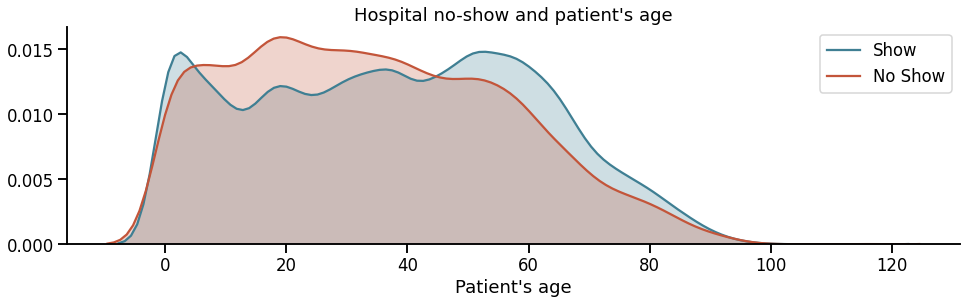

In [100]:
# plot the age
fig, ax = plt.subplots(figsize=(16, 4))
sns.kdeplot(no_show_df.loc[~no_show_df.noShow].age, shade=1,  label = "Show")
sns.kdeplot(no_show_df.loc[no_show_df.noShow].age, shade=1, label = "No Show")
ax.set_title("Hospital no-show and patient's age")
ax.set_xlabel("Patient's age")
sns.despine()
ax.legend()
plt.show()

The age seem to be correlated with the likelihood of having an appointment no-show. The two curves show two peaks for appointments when the patient shows up: at age 0 and around age 50 and older. On contrary, patients in between those ages seem to be more likely not to show up to appointments.

handicap  numObservations
0         0           108285
1         1             2042
2         2              183
3         3               13
4         4                3


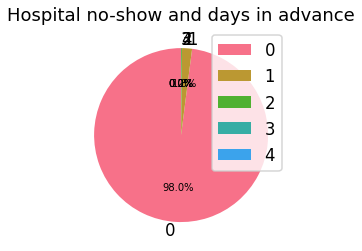

In [101]:
occurrences_count = no_show_df[["handicap","appointmentId"]]\
                            .groupby("handicap")["appointmentId"]\
                            .count().reset_index().rename(columns={"appointmentId" : "numObservations"})

print(occurrences_count)
with sns.color_palette("husl"):
       fig, ax = plt.subplots(figsize=(12, 4))
       ax.pie(occurrences_count.numObservations, 
              labels=occurrences_count.handicap, 
              autopct='%1.1f%%', 
              startangle=90)
       ax.set_title("Hospital no-show and days in advance")
       ax.legend()
       plt.show()

In [102]:
# as there are too few values for handicap = 1|2|3|4, we can turn this variable into a binary one

no_show_df["handicap"] = no_show_df["handicap"].astype(bool)

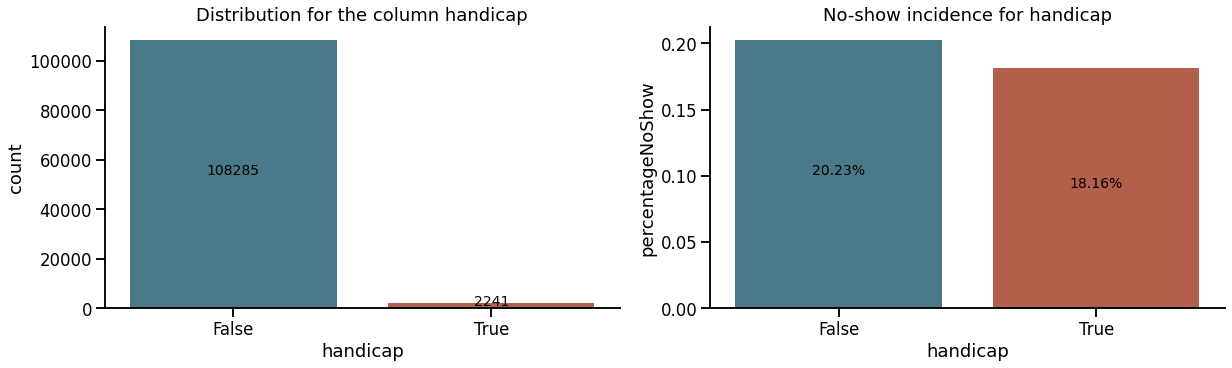


The distributions of no-show between handicap = False and handicap = True are statistically different with a significance of 95%
p-value: 0.01548886382116148



In [103]:
plot_categorical_distribution(no_show_df,"handicap","noShow")

With a significance level of 95%, it can be stated that people with disabilities in this dataset are less likely to not show up to medical appointments.

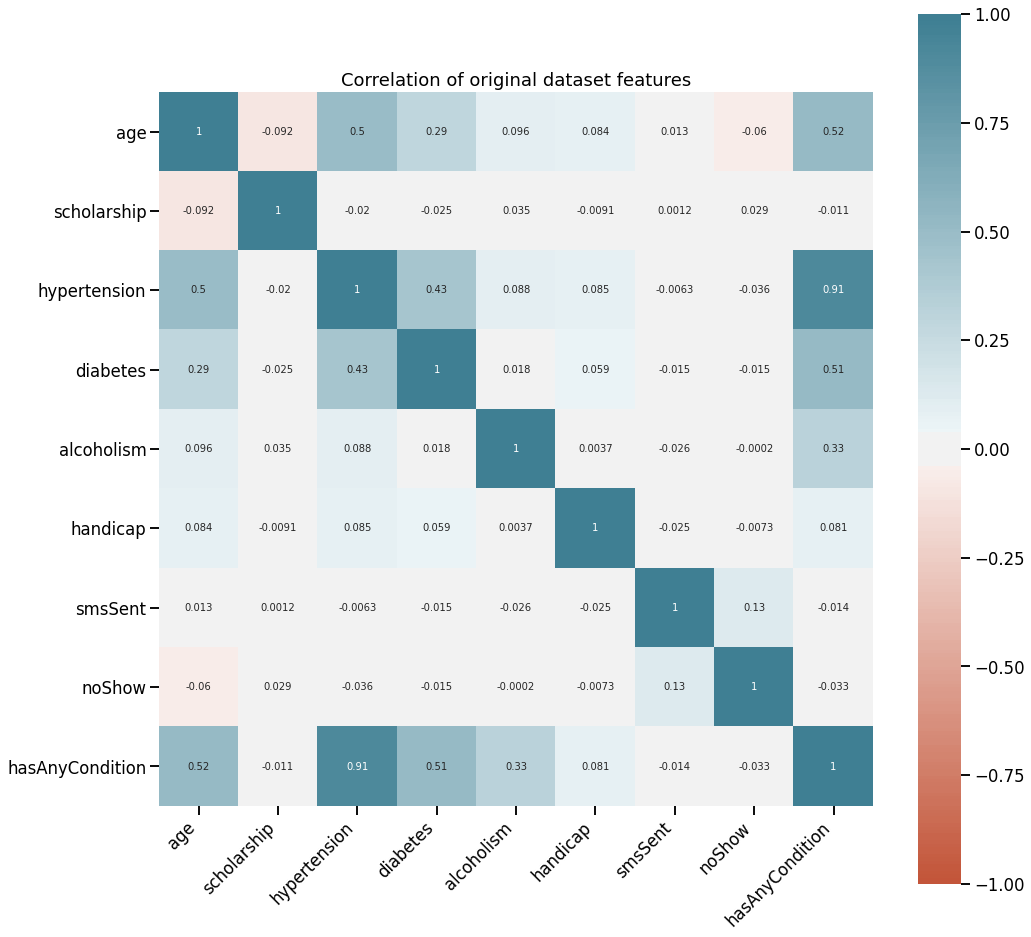

In [104]:
# correlation between those initial features
initial_corr = no_show_df.corr()
plt.figure(figsize=(16,16))
ax = sns.heatmap(
    initial_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Correlation of original dataset features")
plt.show()

### Neighborhood

In [105]:
# how appointment are distributed across different neighborhoods in Vitoria. 
occurrences_count = no_show_df[["neighborhood","noShow"]]\
                        .groupby(["neighborhood"])\
                        .noShow\
                        .agg([np.mean,"count"])\
                        .rename(columns={"mean":"percentageNoShow", "count": "numAppointments"})\
                        .reset_index()

print(color.BOLD,"NEIGHBORHOOD WITH HIGHEST NO-SHOW RATE",color.END)
print(occurrences_count.sort_values(by = "percentageNoShow",ascending=False).head(10))
print()
print(color.BOLD,"NEIGHBORHOOD WITH LOWEST NO-SHOW RATE",color.END)
print(occurrences_count.sort_values(by = "percentageNoShow",ascending=False).tail(10))

 NEIGHBORHOOD WITH HIGHEST NO-SHOW RATE 
                   neighborhood  percentageNoShow  numAppointments
34  ILHAS OCEÂNICAS DE TRINDADE          1.000000                2
70                SANTOS DUMONT          0.289185             1276
61                SANTA CECÍLIA          0.274554              448
62                  SANTA CLARA          0.264822              506
36                      ITARARÉ          0.262664             3514
40            JESUS DE NAZARETH          0.243954             2853
28                        HORTO          0.240000              175
33             ILHA DO PRÍNCIPE          0.234775             2266
9                     CARATOÍRA          0.230409             2565
1                    ANDORINHAS          0.230327             2262

 NEIGHBORHOOD WITH LOWEST NO-SHOW RATE 
         neighborhood  percentageNoShow  numAppointments
19          DO QUADRO          0.164900              849
39    JARDIM DA PENHA          0.162755             3877
66       S

In [106]:
# plot a few distributions out of this data to understand the different behaviors
occurrences_count.describe()

,percentageNoShow,numAppointments
count,81.000000,81.000000
mean,0.205428,1364.518519
std,0.097230,1369.191779
min,0.000000,1.000000
25%,0.179907,413.000000
50%,0.197588,851.000000
75%,0.217454,2018.000000
max,1.000000,7717.000000


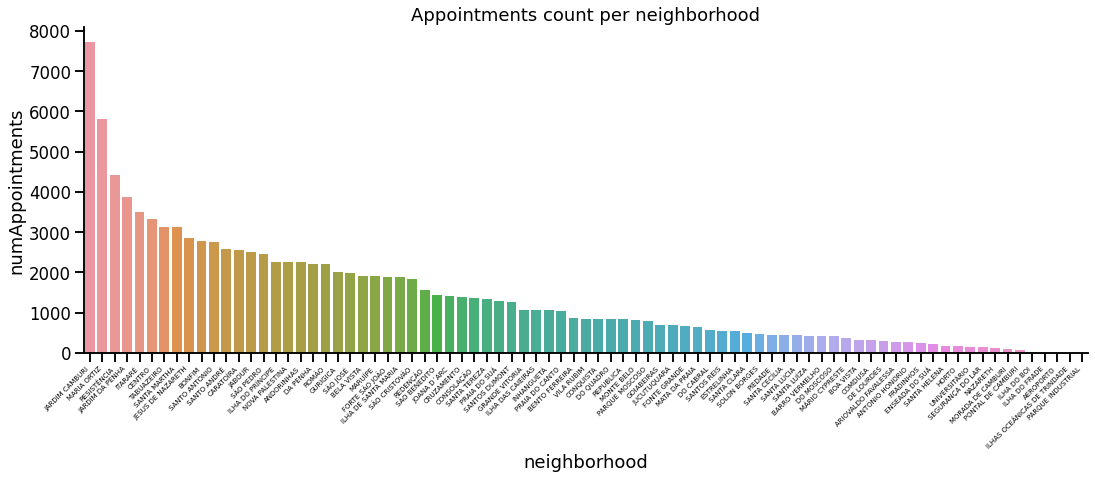

In [107]:
neighborhood_order = occurrences_count\
                    .sort_values(by="numAppointments",ascending=False)\
                    .neighborhood.tolist()

plt.figure(figsize=(18,6))
ax = sns.barplot(x = occurrences_count.neighborhood, 
                 y = occurrences_count.numAppointments,
                 order = neighborhood_order)
ax.set_title("Appointments count per neighborhood")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right",fontsize=7)
sns.despine()
plt.show()

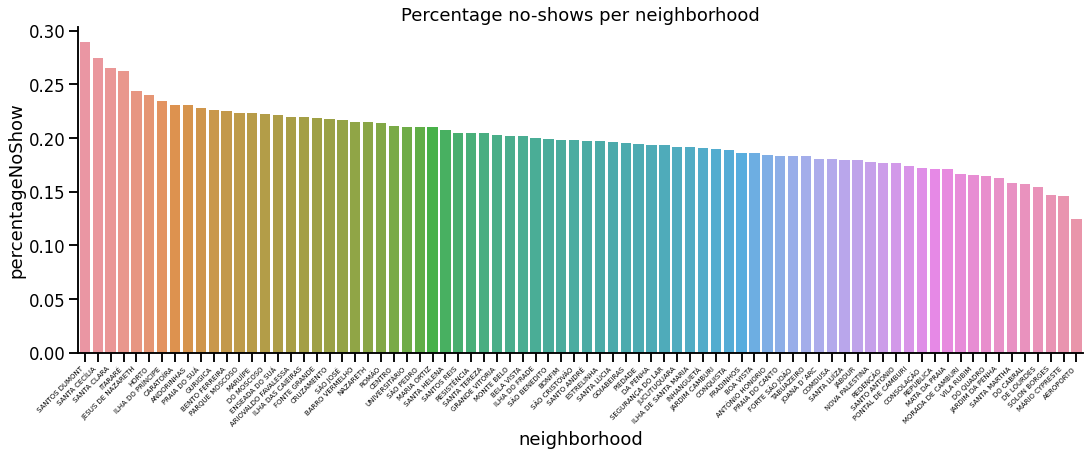

In [108]:
# filtering out the neighborhood with 100% no-show rate or the one with no-show lower than 10%
occurrences_count_filtered = occurrences_count.loc[(occurrences_count.percentageNoShow <1) &
                                                   ((occurrences_count.percentageNoShow >=0.1))]
neighborhood_order = occurrences_count_filtered\
                    .sort_values(by="percentageNoShow",ascending=False)\
                    .neighborhood.tolist()

plt.figure(figsize=(18,6))
ax = sns.barplot(x = occurrences_count_filtered.neighborhood, 
                 y = occurrences_count_filtered.percentageNoShow,
                 order = neighborhood_order)
ax.set_title("Percentage no-shows per neighborhood")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right",fontsize=7)
sns.despine()
plt.show()

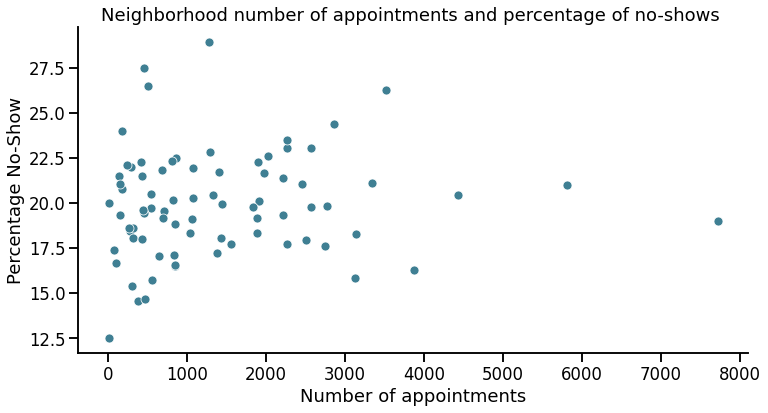

In [109]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x = occurrences_count_filtered.numAppointments,
                     y = 100*occurrences_count_filtered.percentageNoShow,
                     legend=False)
ax.set_title("Neighborhood number of appointments and percentage of no-shows ")
ax.set_xlabel("Number of appointments")
ax.set_ylabel("Percentage No-Show")
sns.despine()
plt.show()

* **percentageNoShow** goes has value ranging from 0% to 100%. We are however talking about neighborhoods that have very little records in the data (1 appointment for the neighborhood with 0% no-shows, 2 appointments for the neighborhood with 100% no-show rate)
* Of the 81 neighborhoods in the dataset, there are several for which the **numAppointments** is very low. 

There are two alternatives to deal with this:
* Group all neighborhoods below a given threshold of number of appointments in a bucket call "OTHER", or
* Try to extract additional data from these neighborhoods

I will first try with the second option, using the Google Maps API to translate the neighborhoods into lat and long coordinates, and try to add those and other features to the dataset.

The code used to build this dataset can be found under 'utils/geocode_neighborhoods.py'.

In [110]:
occurrences_count.neighborhood.to_csv("data/list_of_neighborhoods.csv",index=False,header=False)

# run the script 
#!python utils/geocode_neighborhoods.py

geocoded_neighborhoods = pd.read_csv("data/geocoded_neighborhoods.csv")
print(geocoded_neighborhoods.head())
# normalize the location data
neighborhoods = geocoded_neighborhoods["neighborhood"]
geocoded_neighborhoods = geocoded_neighborhoods.drop("neighborhood", axis = 1)
geocoded_neighborhoods = (geocoded_neighborhoods-geocoded_neighborhoods.mean())/geocoded_neighborhoods.std()
geocoded_neighborhoods["neighborhood"] = neighborhoods
print("Normalized df:")
print(geocoded_neighborhoods.head())
geocoded_neighborhoods.describe()

neighborhood        lat        lon  distanceFromCenter  \
0            AEROPORTO -20.261651 -40.283332            4.188695   
1           ANDORINHAS -20.287964 -40.305672            1.486764   
2      ANTÔNIO HONÓRIO -20.263121 -40.298013            3.826237   
3  ARIOVALDO FAVALESSA -20.314683 -40.356385            6.606019   
4       BARRO VERMELHO -20.294978 -40.298013            0.374139   

   distanceFromCenterLat  distanceFromCenterLon  
0               3.981838               1.299899  
1               1.068753               1.033523  
2               3.819098               0.233590  
3               1.889234               6.330456  
4               0.292258               0.233590  
Normalized df:
        lat       lon  distanceFromCenter  distanceFromCenterLat  \
0  1.190492 -0.160936           -0.180164               0.588399   
1  0.404723 -0.175792           -0.197494              -0.386704   
2  1.146595 -0.170699           -0.182489               0.533924   
3 -0.393156 -0

,lat,lon,distanceFromCenter,distanceFromCenterLat,distanceFromCenterLon
count,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01,8.100000e+01
mean,-5.107437e-14,1.077704e-14,-2.295832e-17,3.047973e-16,-6.236438e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.167963e+00,-2.095151e-01,-2.046296e-01,-7.431233e-01,-2.013579e-01
25%,-3.785358e-01,-1.961564e-01,-1.923803e-01,-4.248435e-01,-1.949501e-01
50%,1.277385e-02,-1.830055e-01,-1.841465e-01,-1.642891e-01,-1.855588e-01
75%,5.183329e-01,-1.715478e-01,-1.748781e-01,7.676790e-02,-1.719026e-01
max,1.290402e+00,7.122277e+00,7.133528e+00,7.054310e+00,7.132485e+00


In [111]:
neighborhood_stats_df = pd.merge(occurrences_count_filtered,geocoded_neighborhoods, on="neighborhood",how="left")
neighborhood_stats_df.sort_values(by="lon",ascending=False).head()


,neighborhood,percentageNoShow,numAppointments,lat,lon,distanceFromCenter,distanceFromCenterLat,distanceFromCenterLon
36,JARDIM CAMBURI,0.189841,7717,1.263117,-0.149047,-0.173027,0.678522,-0.181284
0,AEROPORTO,0.125000,8,1.190492,-0.160936,-0.180164,0.588399,-0.193244
31,ILHA DO FRADE,0.200000,10,-0.037239,-0.161710,-0.198635,-0.553741,-0.194023
43,MATA DA PRAIA,0.170807,644,0.788316,-0.166879,-0.190882,0.089317,-0.199223
52,PRAIA DO CANTO,0.183575,1035,0.056468,-0.166879,-0.204280,-0.670027,-0.199223


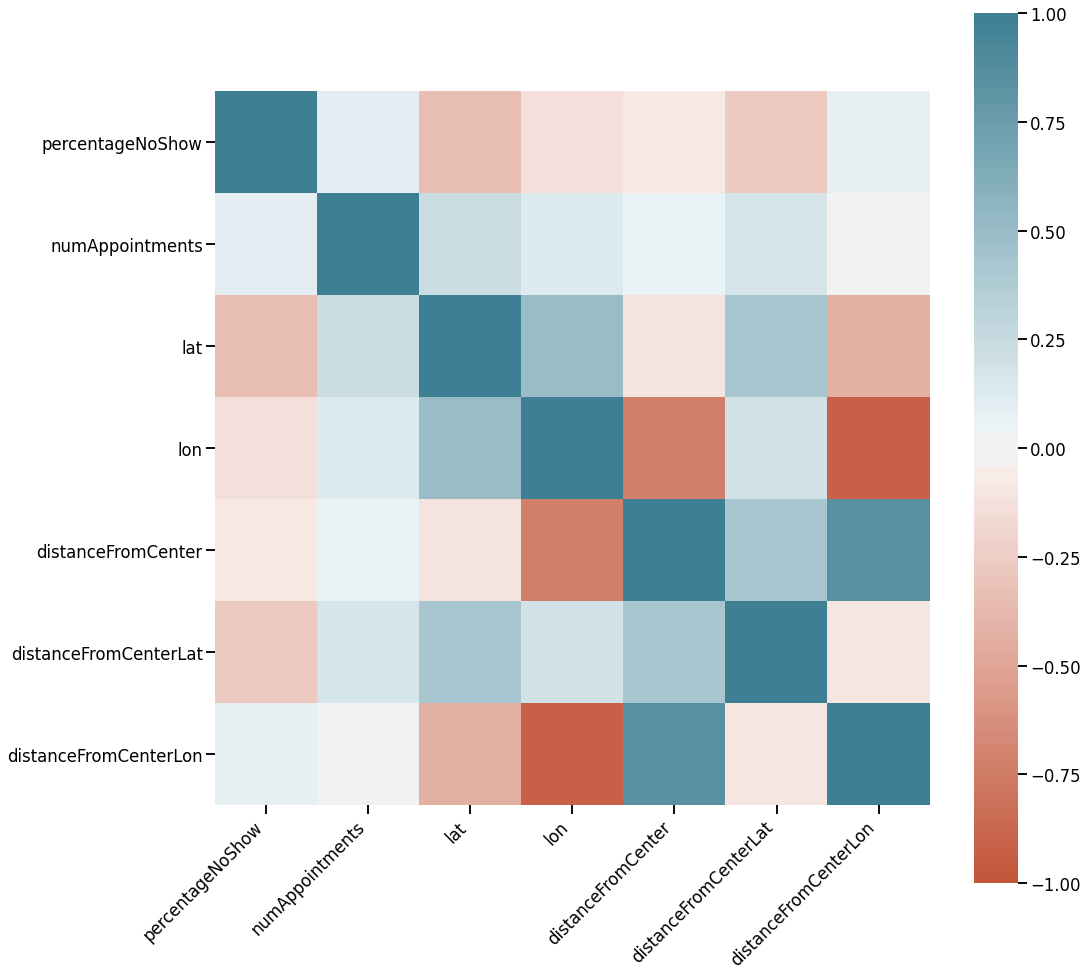

In [112]:
geo_corr = neighborhood_stats_df.corr()
plt.figure(figsize=(16,16))
ax = sns.heatmap(
    geo_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

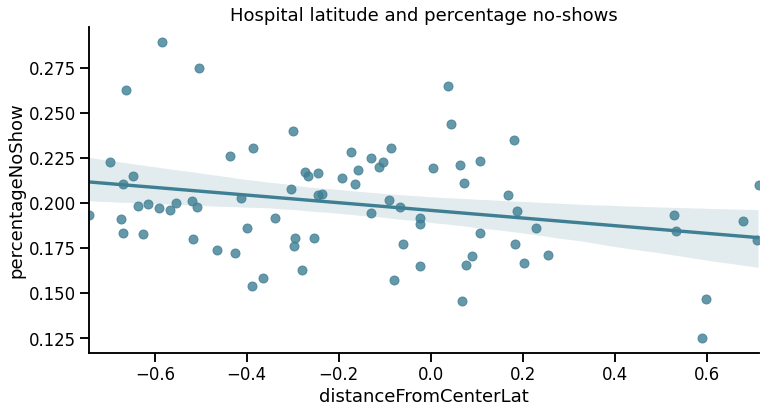

In [113]:
# there seems to be a strong correlation between the percentage of no shows 
# and 'distanceFromCenterLat'

plt.figure(figsize=(12,6))
ax = sns.regplot(x = neighborhood_stats_df.distanceFromCenterLat,
                     y = neighborhood_stats_df.percentageNoShow)
ax.set_title("Hospital latitude and percentage no-shows")
sns.despine()

plt.show()


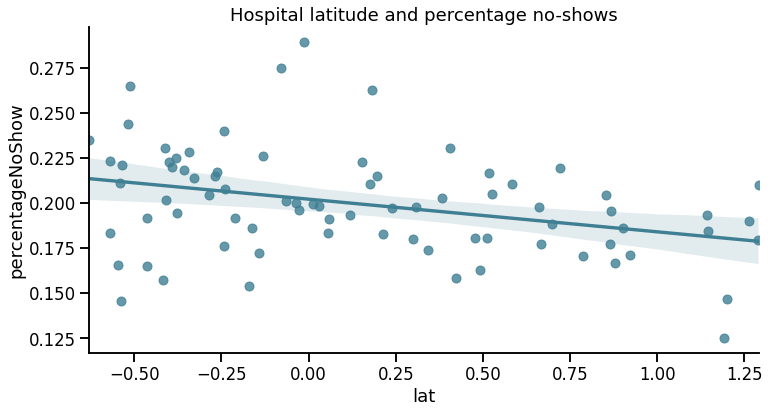

In [114]:
plt.figure(figsize=(12,6))
ax = sns.regplot(x = neighborhood_stats_df.lat,
                     y = neighborhood_stats_df.percentageNoShow)
ax.set_title("Hospital latitude and percentage no-shows")
sns.despine()

plt.show()


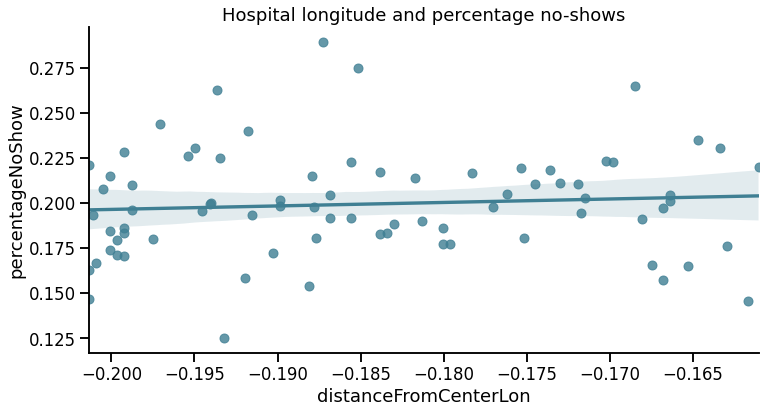

In [115]:
plt.figure(figsize=(12,6))
ax = sns.regplot(x = neighborhood_stats_df.distanceFromCenterLon,
                     y = neighborhood_stats_df.percentageNoShow)
ax.set_title("Hospital longitude and percentage no-shows")
sns.despine()

plt.show()

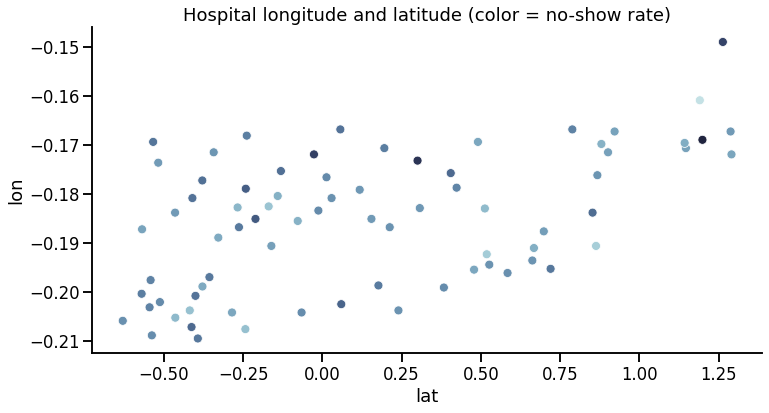

In [116]:
plt.figure(figsize=(12,6))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x = neighborhood_stats_df.lat,
                     y = neighborhood_stats_df.lon,
                     hue = occurrences_count_filtered.percentageNoShow,
                     palette=cmap,
                     legend=False)
ax.set_title("Hospital longitude and latitude (color = no-show rate)")
sns.despine()

plt.show()

**Observations:**
* There seems to be a slight correlation between the latitude and the percentage of no-shows. Longitude and the distance from center does not seem to affect no-show too much

### Time

We will begin by setting some space and time coordinates to understand the context of the dataset. When do these observations take place? Where? We start by looking at scheduledDay and appointmentDay.


In [117]:
# min and max of appointment day
print("Min appointment date:",no_show_df.appointmentDay.min())
print("Max appointment date:",no_show_df.appointmentDay.max())
print("\nThe appointments in the dataset refer to a period spanning over {} days"\
      .format((no_show_df.appointmentDay.max() - no_show_df.appointmentDay.min()).days))

Min appointment date: 2016-04-29 00:00:00
Max appointment date: 2016-06-08 00:00:00

The appointments in the dataset refer to a period spanning over 40 days


In [118]:
#min and max of appointment day
print("Min:",no_show_df.scheduledDay.min())
print("Max:",no_show_df.scheduledDay.max())
print("\nThe appointments in the dataset were scheduled over a period of {} days"\
      .format((no_show_df.scheduledDay.max() - no_show_df.scheduledDay.min()).days))

Min: 2015-11-10 07:13:56
Max: 2016-06-08 20:07:23

The appointments in the dataset were scheduled over a period of 211 days


A couple of observations on these two columns:
* The meaning of the two columns could have been ambigous by the description of the dataset, but it becomes clear by looking at the data. The column appointmentDay refers to the day when the medical appointment is planned to take place, while the scheduledDay column refers to the day (and time) when the appointment was scheduled. This can be observed by looking at the values of the scheduledDay variable, which are prior to the appointmentDay one.
* The sensitivity of the two columns is different: the scheduledDay column is defined up to a time in seconds, while the appointmentDay column is defined only at a date level. While appreciating that this might have been a way to anonimyze the data, having information about the moment of the day of the appointment would have been very useful. For example, we could have learnt that patients might not show up due to traffic jams in rush hours. For further version of this dataset, having even a binned reference to the appointment time would be preferrable.


We can now use these two columns to build additional features from the intrinsic information included in the datetime.

In [119]:
## appointmentDay
# we will skip the year as it has no variability on this feature
no_show_df["appointmentDayMonth"] = no_show_df.appointmentDay.dt.month
no_show_df["appointmentDayDay"] = no_show_df.appointmentDay.dt.day
no_show_df["appointmentDayDayOfWeek"] = no_show_df.appointmentDay.dt.day_name()
# compute normalized value 
no_show_df["appointmentDayMonthProgress"] = no_show_df.appointmentDay.dt.day /no_show_df.appointmentDay.dt.days_in_month

## scheduledDay 
no_show_df["scheduledDayMonth"] = no_show_df.scheduledDay.dt.month
no_show_df["scheduledDayDayOfWeek"] = no_show_df.scheduledDay.dt.day_name()
# compute normalized value 
no_show_df["scheduledDayMonthProgress"] = no_show_df.scheduledDay.dt.day /no_show_df.scheduledDay.dt.days_in_month
no_show_df["scheduledDayHour"] = no_show_df.scheduledDay.dt.hour
no_show_df["scheduledDayMinute"] = no_show_df.scheduledDay.dt.minute


# how many days before was the appointment taken?
no_show_df["daysInAdvance"] = (no_show_df.appointmentDay.dt.date - no_show_df.scheduledDay.dt.date)\
                                .apply(lambda x: x.days)

In [120]:
# let's analyze the new columns that we created
new_cols = list(set(no_show_df.columns) - set(list(new_column_names_and_formats.keys())))
print("New columns created:")
print(", ".join(new_cols))
no_show_df[new_cols].head()

New columns created:
hasAnyCondition, scheduledDayHour, scheduledDayMonth, appointmentDayDay, appointmentDayMonth, daysInAdvance, scheduledDayMinute, appointmentDayMonthProgress, scheduledDayMonthProgress, scheduledDayDayOfWeek, appointmentDayDayOfWeek


,hasAnyCondition,scheduledDayHour,scheduledDayMonth,appointmentDayDay,appointmentDayMonth,daysInAdvance,scheduledDayMinute,appointmentDayMonthProgress,scheduledDayMonthProgress,scheduledDayDayOfWeek,appointmentDayDayOfWeek
0,True,18,4,29,4,0,38,0.966667,0.966667,Friday,Friday
1,False,16,4,29,4,0,8,0.966667,0.966667,Friday,Friday
2,False,16,4,29,4,0,19,0.966667,0.966667,Friday,Friday
3,False,17,4,29,4,0,29,0.966667,0.966667,Friday,Friday
4,True,16,4,29,4,0,7,0.966667,0.966667,Friday,Friday


Now we can have a look at those variables. Let's start by looking at the day when the appointment is scheduled and compare it with the rate of no shows

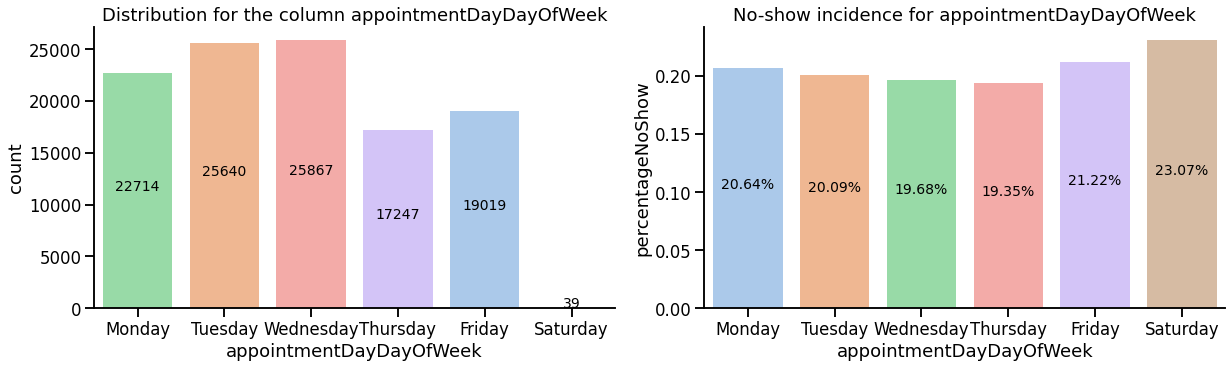

In [121]:
day_of_week_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"] #no appointments on sunday
with sns.color_palette("pastel"):
    plot_categorical_distribution(no_show_df,"appointmentDayDayOfWeek","noShow", ncols=2, order=day_of_week_order)


In the days in the middle of the week (Tuesday to Thursday), no-show seem to be a bit lower than in other days.

How about the beginning vs. the end of the month?

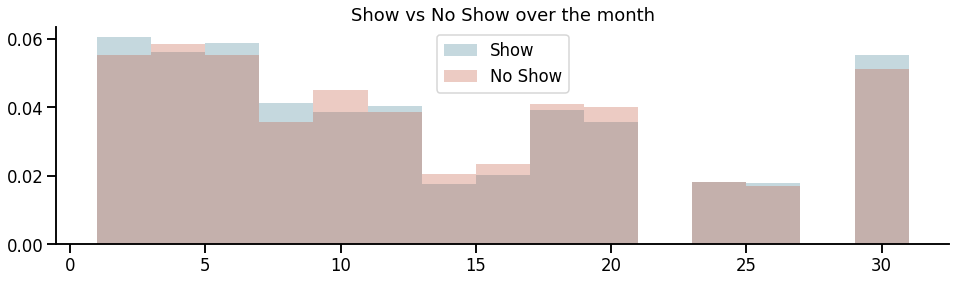

In [122]:
sns.set_palette(sns.diverging_palette(220, 20, n=2))

fig, ax = plt.subplots(figsize=(16, 4))

ax.hist(x="appointmentDayDay", data = no_show_df.loc[~no_show_df.noShow], bins=15, density=True,
        label='Show',alpha=0.3)
ax.hist(x="appointmentDayDay", data = no_show_df.loc[no_show_df.noShow], bins=15, density=True,
        label='No Show', alpha=0.3)
#ax = sns.distplot(no_show_df.appointmentDayMonthProgress,hist_kws=true, bins=15)
ax.set_title("Show vs No Show over the month")
ax.legend()
sns.despine()

plt.show()

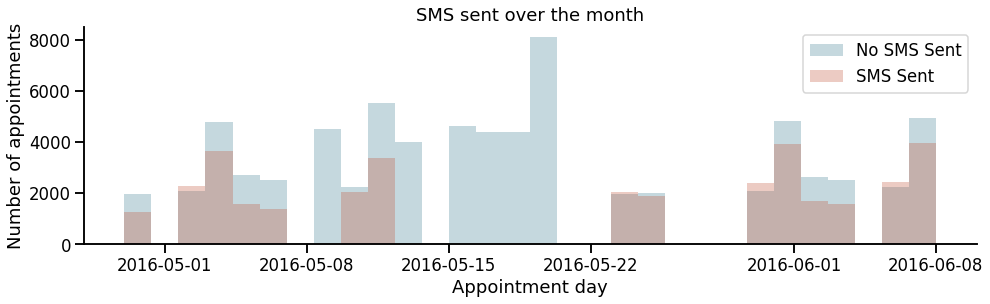

In [123]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.hist(x="appointmentDay", data = no_show_df.loc[~no_show_df.smsSent], bins=30, density=False,
        label='No SMS Sent',alpha=0.3)
ax.hist(x="appointmentDay", data = no_show_df.loc[no_show_df.smsSent], bins=30, density=False,
        label='SMS Sent', alpha=0.3)
#ax = sns.distplot(no_show_df.appointmentDayMonthProgress,hist_kws=true, bins=15)
ax.set_title("SMS sent over the month")
ax.set_xlabel("Appointment day")
ax.set_ylabel("Number of appointments")
ax.legend()
sns.despine()

plt.show()

In [124]:
# what are the days for which no SMS were sent?
count_smsSent_per_day = no_show_df[["smsSent","appointmentDay"]]\
                        .groupby("appointmentDay")["smsSent"].agg(["sum","count"])\
                        .rename(columns={"sum":"numSmsSent", "count": "numAppointments"})\
                        .reset_index()

print("Days with recorded appointments when no SMS has been sent:")
days_with_no_SMS = count_smsSent_per_day["appointmentDay"].loc[count_smsSent_per_day.numSmsSent == 0]
print(day_of_week_order)
no_show_df = no_show_df.loc[~no_show_df.appointmentDay.isin(days_with_no_SMS)]


Days with recorded appointments when no SMS has been sent:
['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


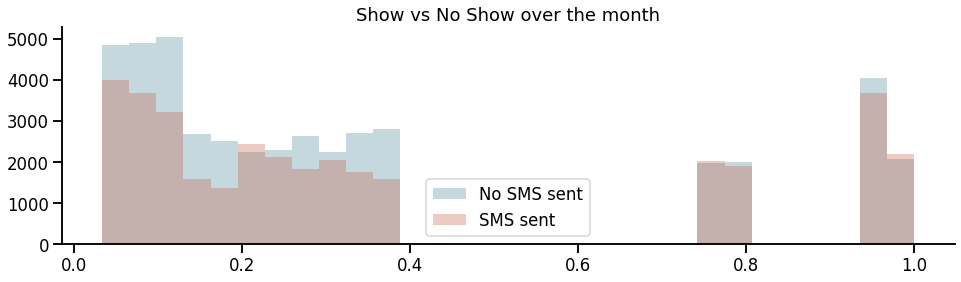

In [125]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.hist(x="appointmentDayMonthProgress", data = no_show_df.loc[~no_show_df.smsSent], bins=30, density=False,
        label='No SMS sent',alpha=0.3)
ax.hist(x="appointmentDayMonthProgress", data = no_show_df.loc[no_show_df.smsSent], bins=30, density=False,
        label='SMS sent', alpha=0.3)
#ax = sns.distplot(no_show_df.appointmentDayMonthProgress,hist_kws=true, bins=15)
ax.set_title("Show vs No Show over the month")
ax.legend()
sns.despine()
plt.show()

We went back to the variable SMS sent, which had one of the highest correlations in the datsaset with no-show. Unfortunately, it seems that no SMS were sent for a period of roughly 10 days. This is a serious problem for our dataset, as the data is clearly biased, but the number of records showing this occurrence is a significant chunk of our dataset.

The main question to be asked here is: were SMS actually not sent, or was there an issue in recording this in the dataset?

After training and validating a machine learning model with both a dataset containing the entire data and with a dataset with these days removed, the tradeoff between losing a significant portion of observations and removing biased data is resolved in favor of keeping a higher number of rows in the dataset. In a real case scenario, these days should be disregarded and further data could be gathered from previous months. Unfortunately, this is not an option available in this case.

Finally, we'll look into the daysInAdvance engineered featured and how it affects the probability of no-show

In [126]:
# first, we analyze the negative values
print(no_show_df.loc[no_show_df["daysInAdvance"]<0])

#they are only 5 rows, can be dropped
no_show_df = no_show_df.drop(index=no_show_df.loc[no_show_df["daysInAdvance"]<0].index)


patientId appointmentId gender        scheduledDay  \
64175   24252258389979       5664962      F 2016-05-05 13:43:58   
71533  998231581612122       5686628      F 2016-05-11 13:49:20   
72362    3787481966821       5655637      M 2016-05-04 06:50:57   

      appointmentDay  age   neighborhood  scholarship  hypertension  diabetes  \
64175     2016-05-04   22     CONSOLAÇÃO        False         False     False   
71533     2016-05-05   81  SANTO ANTÔNIO        False         False     False   
72362     2016-05-03    7     TABUAZEIRO        False         False     False   

       ...  appointmentDayMonth  appointmentDayDay  appointmentDayDayOfWeek  \
64175  ...                    5                  4                Wednesday   
71533  ...                    5                  5                 Thursday   
72362  ...                    5                  3                  Tuesday   

       appointmentDayMonthProgress  scheduledDayMonth  scheduledDayDayOfWeek  \
64175                 

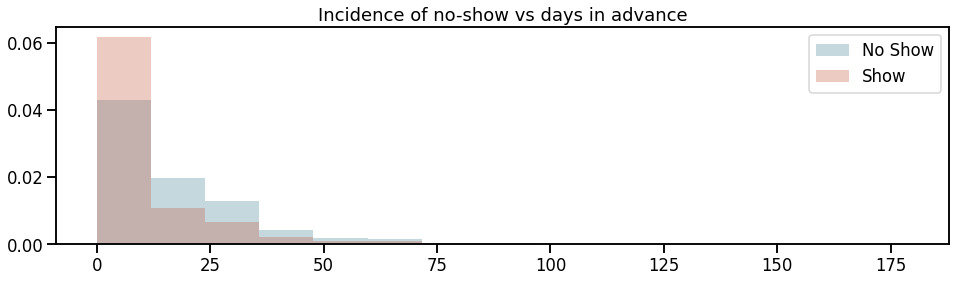

In [127]:
# Do daysinAdvance influence the probability of a no show?
fig, ax = plt.subplots(figsize=(16, 4))
ax.hist(x="daysInAdvance", data = no_show_df.loc[no_show_df.noShow], bins=15, density=True,
        label='No Show',alpha=0.3)
ax.hist(x="daysInAdvance", data = no_show_df.loc[~no_show_df.noShow], bins=15, density=True,
        label='Show',alpha=0.3)
ax.set_title("Incidence of no-show vs days in advance")
ax.legend()
plt.show()


The more days ahead the appointment was booked, the more likely it is for patients to not show up.

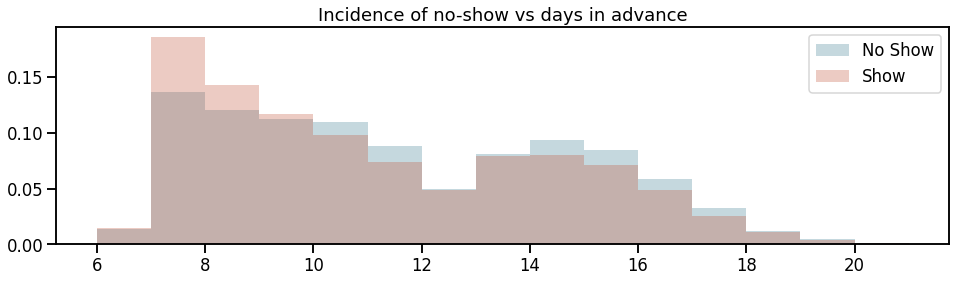

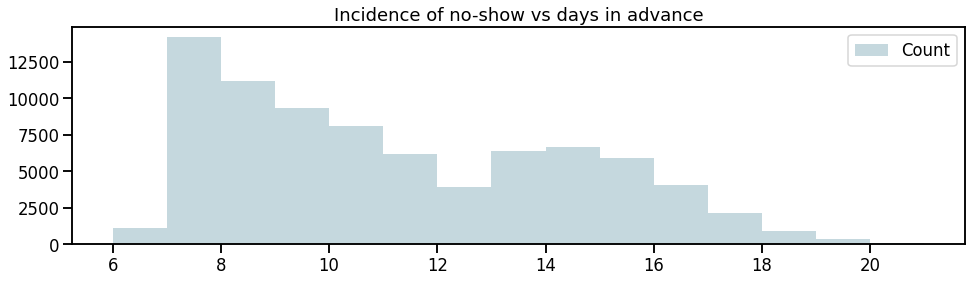

In [128]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.hist(x="scheduledDayHour", data = no_show_df.loc[no_show_df.noShow], bins=15, density=True,
        label='No Show',alpha=0.3)
ax.hist(x="scheduledDayHour", data = no_show_df.loc[~no_show_df.noShow], bins=15, density=True,
        label='Show',alpha=0.3)
ax.set_title("Incidence of no-show vs days in advance")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
ax.hist(x="scheduledDayHour", data = no_show_df, bins=15, density=False,
        label='Count',alpha=0.3)
ax.set_title("Incidence of no-show vs days in advance")
ax.legend()
plt.show()

There seems to be a correlation between the hour when the appointment was scheduled and the incidence of no-show. As most patients had a daysInAdvance value of 0, the scheduledDayHour might be partially correlated to the hour of the appointment.

Finally, we can look into the duplicated patients IDs. Would it be possible to use prior behaviors as a predictive feature for no shows?

In [129]:
no_show_df["previouslyMissed"] = no_show_df.sort_values(['appointmentDay','scheduledDay','patientId'],ascending=True)\
.groupby(['patientId'])["noShow"].transform(pd.Series.cumsum)

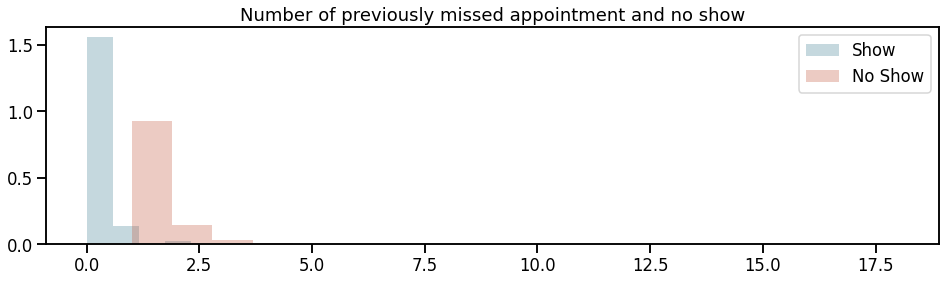

In [130]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.hist(x="previouslyMissed", data = no_show_df.loc[~no_show_df.noShow], bins=19, density=True,
        label='Show',alpha=0.3)
ax.hist(x="previouslyMissed", data = no_show_df.loc[no_show_df.noShow], bins=19, density=True,
        label='No Show', alpha=0.3)
ax.set_title("Number of previously missed appointment and no show")
ax.legend()
plt.show()


Having missed an appointment before seem to be a strong predictor of not showing up to an appointment in the future.

In [131]:
no_show_df["numOtherAppointmentsOnSameDay"] = no_show_df.sort_values(['appointmentDay','scheduledDay','patientId'],ascending=True)\
.groupby(['patientId','appointmentDay'])["appointmentId"].transform(pd.Series.nunique)
no_show_df["numOtherAppointmentsOnSameDay"] = no_show_df["numOtherAppointmentsOnSameDay"] - 1


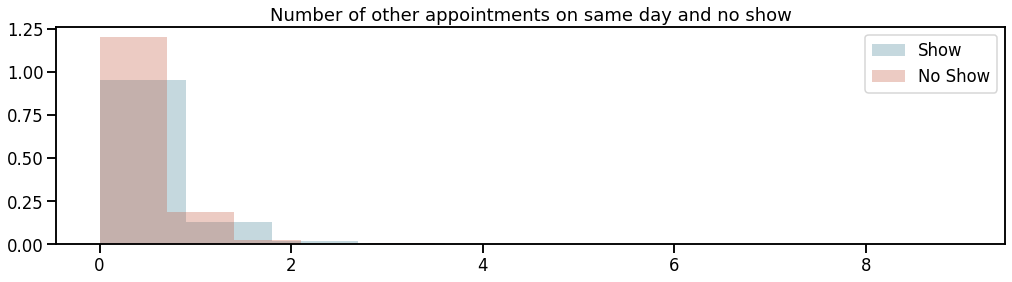

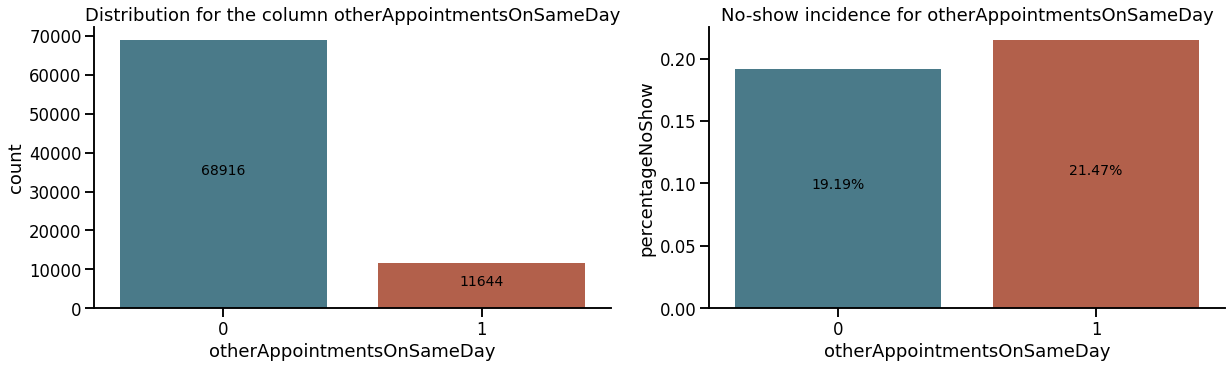


The distributions of no-show between otherAppointmentsOnSameDay = 0 and otherAppointmentsOnSameDay = 1 are statistically different with a significance of 95%
p-value: 8.407243276375598e-09



In [132]:
fig, ax = plt.subplots(figsize=(17, 4))
ax.hist(x="numOtherAppointmentsOnSameDay", data = no_show_df.loc[~no_show_df.noShow], bins=10, density=True,
        label='Show',alpha=0.3)
ax.hist(x="numOtherAppointmentsOnSameDay", data = no_show_df.loc[no_show_df.noShow], bins=10, density=True,
        label='No Show', alpha=0.3)
ax.set_title("Number of other appointments on same day and no show")
ax.legend()
plt.show()

no_show_df["otherAppointmentsOnSameDay"] = (no_show_df["numOtherAppointmentsOnSameDay"] > 0)*1
plot_categorical_distribution(no_show_df,"otherAppointmentsOnSameDay","noShow", ncols=2)



It does not seem that this feature could be a strong predictor of no-shows, although not having other appointments on the same day seems to slightly increase the likelihood of not showing up. Intuitively, this can be seen as coincident appointments are giving patients additional reasons to go to the appointment.

## Exploring the correlation


In [133]:
# dividi le correlation matrix
one_hot_encoded_appointment_DOW = pd.get_dummies(no_show_df.appointmentDayDayOfWeek, prefix="appointmentDayDOW_")
#one_hot_encoded_neighborhood = pd.get_dummies(no_show_df.neighborhood, prefix="Neighborhood_")
no_show_df_extended = pd.concat([no_show_df,one_hot_encoded_appointment_DOW],axis=1)
no_show_df_extended = pd.merge(no_show_df_extended,geocoded_neighborhoods, on="neighborhood",how="left")
corr = no_show_df_extended.corr()

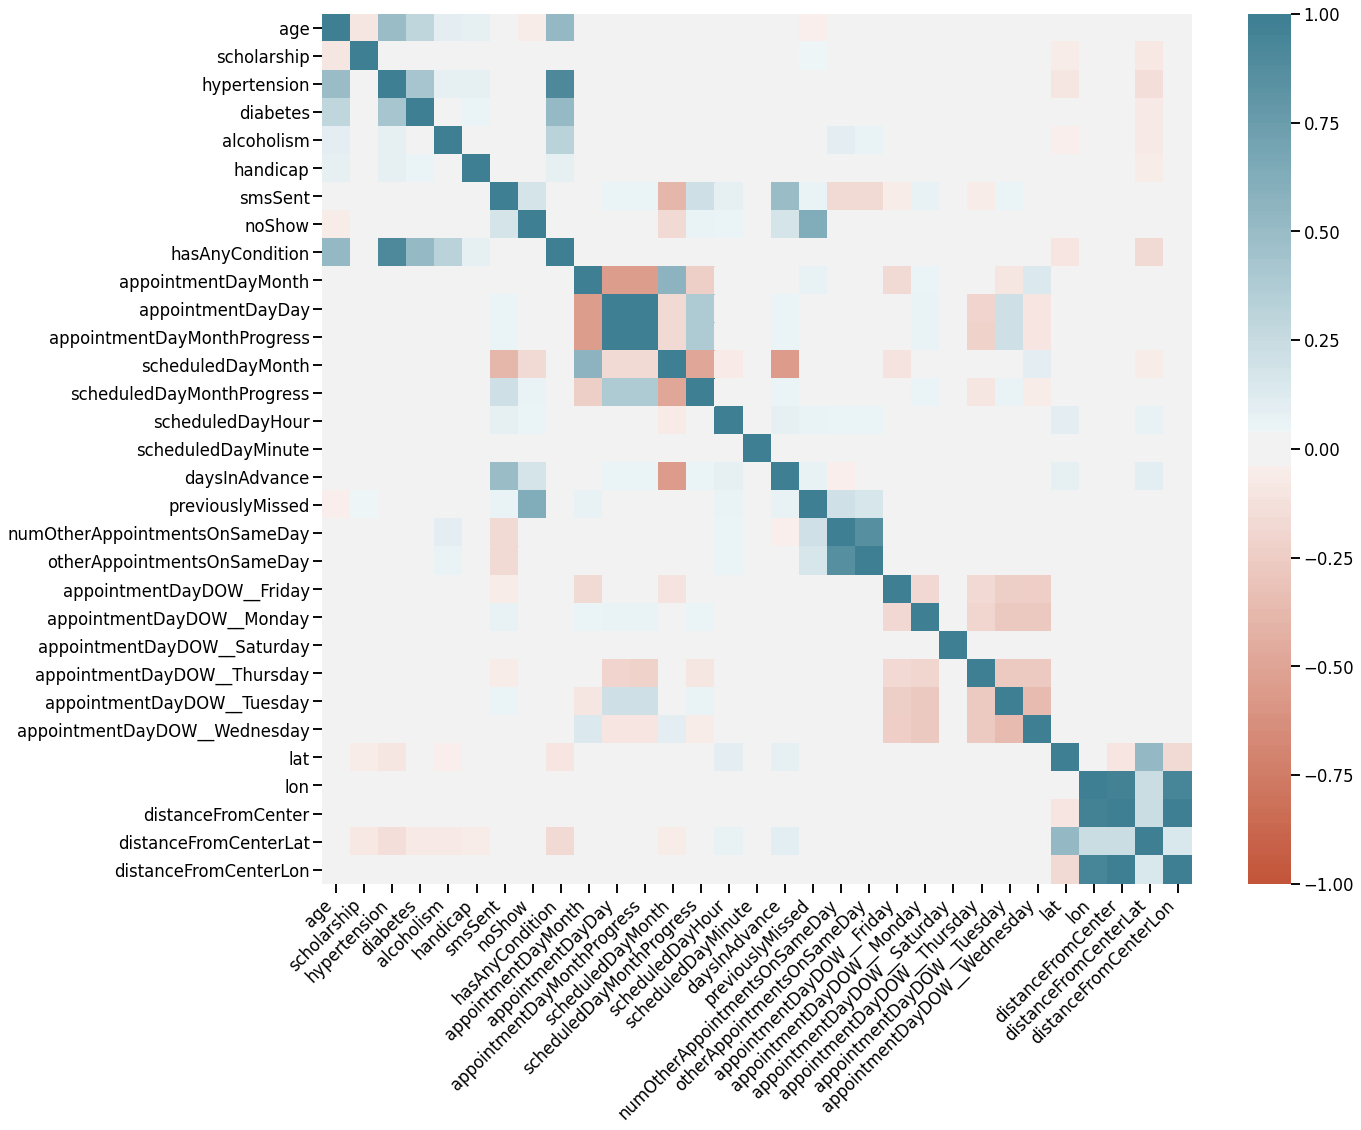

In [134]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

In [135]:
# Overall exploration
no_show_df_extended.describe()

,age,appointmentDayMonth,appointmentDayDay,appointmentDayMonthProgress,scheduledDayMonth,scheduledDayMonthProgress,scheduledDayHour,scheduledDayMinute,daysInAdvance,previouslyMissed,...,appointmentDayDOW__Monday,appointmentDayDOW__Saturday,appointmentDayDOW__Thursday,appointmentDayDOW__Tuesday,appointmentDayDOW__Wednesday,lat,lon,distanceFromCenter,distanceFromCenterLat,distanceFromCenterLon
count,80560.000000,80560.00000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,...,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000,80560.000000
mean,37.222790,5.28817,11.227110,0.365022,4.859881,0.464759,10.761085,28.960787,10.281591,0.347219,...,0.168582,0.000484,0.161072,0.263990,0.266795,0.271017,-0.181778,-0.182743,-0.099857,-0.183364
std,23.102205,0.53427,10.092187,0.327001,0.764035,0.332770,3.217753,17.272362,15.299216,0.706897,...,0.374385,0.021997,0.367600,0.440796,0.442287,0.605831,0.071586,0.070624,0.431865,0.070812
min,0.000000,4.00000,1.000000,0.033333,1.000000,0.032258,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-3.468903,-0.209515,-0.204630,-0.743123,-0.201358
25%,18.000000,5.00000,3.000000,0.100000,4.000000,0.161290,8.000000,14.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.263382,-0.193611,-0.192489,-0.424844,-0.194096
50%,37.000000,5.00000,7.000000,0.233333,5.000000,0.387097,10.000000,29.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.212190,-0.183430,-0.184147,-0.164289,-0.185559
75%,56.000000,6.00000,12.000000,0.387097,5.000000,0.806452,13.000000,44.000000,15.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.698255,-0.173670,-0.174420,0.168520,-0.177023
max,115.000000,6.00000,31.000000,1.000000,12.000000,1.000000,21.000000,59.000000,179.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.290402,3.650120,3.639778,3.704832,3.640572


Filtered out 27 rows based on the distance from center


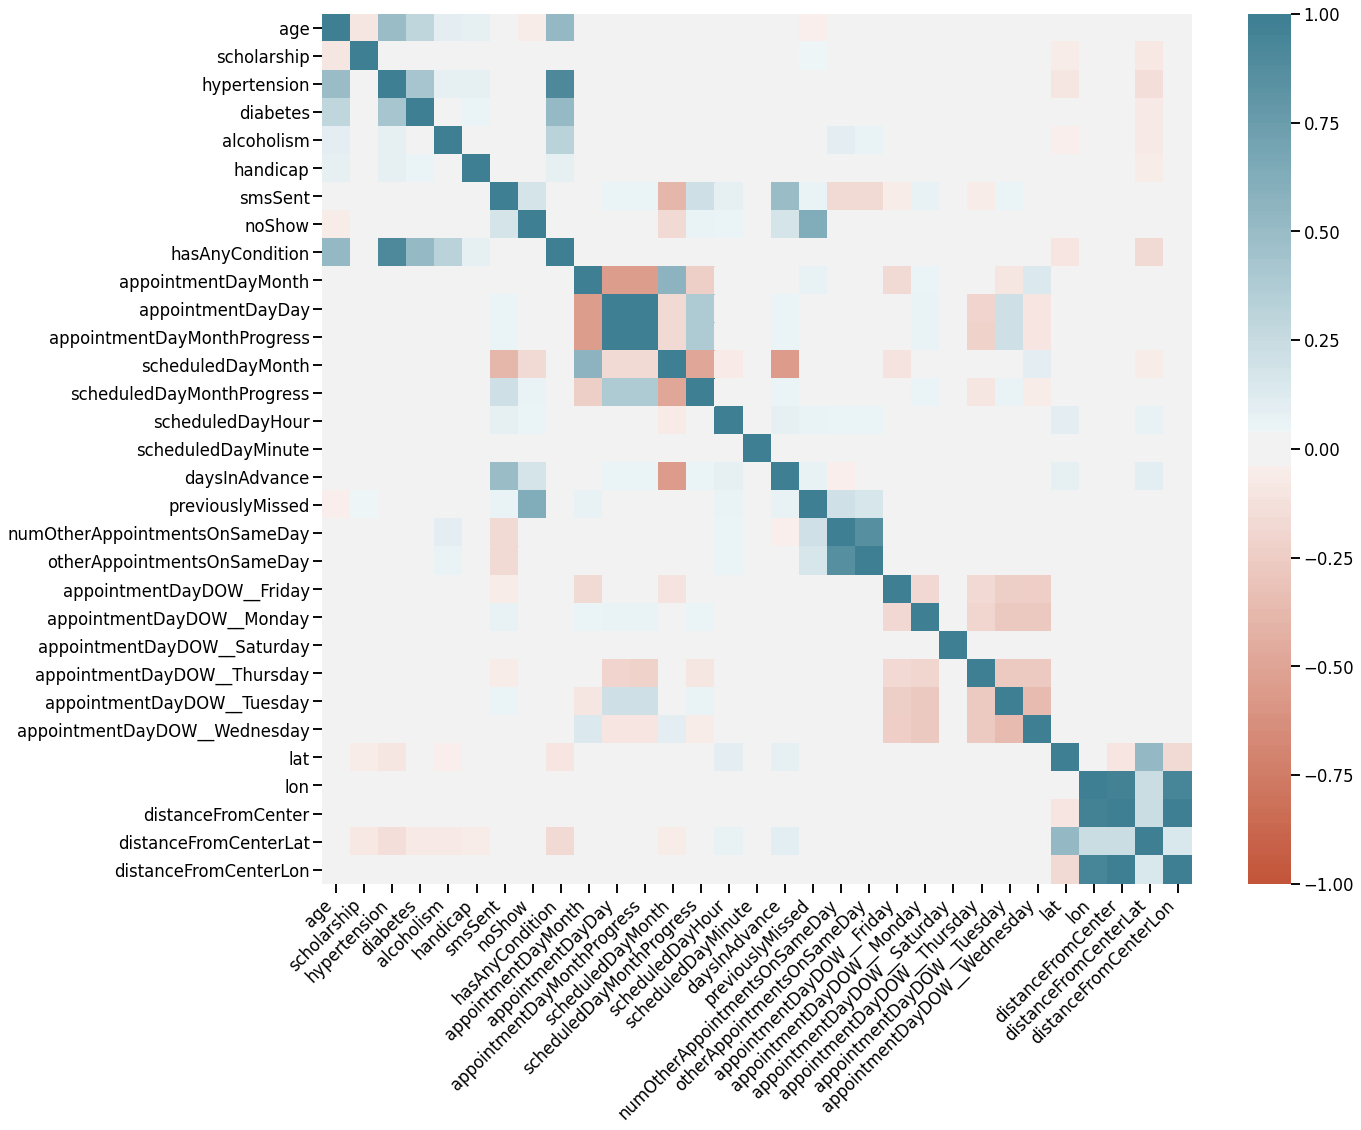

,age,appointmentDayMonth,appointmentDayDay,appointmentDayMonthProgress,scheduledDayMonth,scheduledDayMonthProgress,scheduledDayHour,scheduledDayMinute,daysInAdvance,previouslyMissed,...,appointmentDayDOW__Monday,appointmentDayDOW__Saturday,appointmentDayDOW__Thursday,appointmentDayDOW__Tuesday,appointmentDayDOW__Wednesday,lat,lon,distanceFromCenter,distanceFromCenterLat,distanceFromCenterLon
count,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,...,80533.000000,80533.000000,80533.00000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000
mean,37.220022,5.288242,11.226168,0.364991,4.859846,0.464771,10.761079,28.960588,10.283648,0.347299,...,0.168614,0.000484,0.16104,0.264016,0.266822,0.272254,-0.183060,-0.184022,-0.101112,-0.184644
std,23.103200,0.534254,10.091781,0.326986,0.764105,0.332767,3.217809,17.272605,15.300816,0.706979,...,0.374413,0.022001,0.36757,0.440811,0.442301,0.602134,0.014814,0.010330,0.426425,0.011391
min,0.000000,4.000000,1.000000,0.033333,1.000000,0.032258,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,-0.629942,-0.209515,-0.204630,-0.743123,-0.201358
25%,18.000000,5.000000,3.000000,0.100000,4.000000,0.161290,8.000000,14.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,-0.263382,-0.193611,-0.192489,-0.424844,-0.194096
50%,37.000000,5.000000,7.000000,0.233333,5.000000,0.387097,10.000000,29.000000,4.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.212190,-0.183430,-0.184147,-0.164289,-0.185559
75%,56.000000,6.000000,12.000000,0.387097,5.000000,0.806452,13.000000,44.000000,15.000000,1.000000,...,0.000000,0.000000,0.00000,1.000000,1.000000,0.698255,-0.173670,-0.174420,0.168520,-0.177023
max,115.000000,6.000000,31.000000,1.000000,12.000000,1.000000,21.000000,59.000000,179.000000,18.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.290402,-0.149047,-0.164147,0.712382,-0.161024


In [136]:
no_show_df_extended_filtered_locations = no_show_df_extended.loc[no_show_df_extended["distanceFromCenter"] < 3]
corr_filtered_locations = no_show_df_extended_filtered_locations.corr()
print("Filtered out {} rows based on the distance from center".format(len(no_show_df_extended.loc[no_show_df_extended["distanceFromCenter"] >= 3])))

plt.figure(figsize=(20,16))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()
no_show_df_extended_filtered_locations.describe()

Really few features seem to be correlated with our target variable. SOME ADDITIONAL EXPLANATION HERE.


In [137]:
no_show_df_extended_filtered_locations.to_csv("data/no_show_feature_engineered_no_extreme_locations_no_SMS_issues.csv",index=False)